In [56]:
import numpy as np
import pandas as pd
import nltk
import nltk.corpus
nltk.download('twitter_samples')
nltk.download('movie_reviews')
nltk.download('names')
from nltk.sentiment import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt

# parallel processing
import dask.dataframe as dd
from dask.multiprocessing import get

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\tyler\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\tyler\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package names to
[nltk_data]     C:\Users\tyler\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!


In [6]:
data = pd.read_csv('../complete_data/complete_data_cases.csv')
data.head()

,tweet_id,location,date,likes,retweets,text,index,city,state,is_state,...,Confirmed,Deaths,Recovered,Active,Incident_Rate,Total_Test_Results,Case_Fatality_Ratio,Testing_Rate,People_Tested,Mortality_Rate
0,1.250000e+18,"Pomona, CA",4/4/2020,89921,34665,A day without Hispanics .... this country coul...,1,Pomona,California,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.250000e+18,"Santa Barbara, CA",4/21/2020,34308,5245,XO face masks are back to raise money and Iâ...,2,Santa Barbara,California,False,...,35750.0,1289.0,NaN,NaN,90.422652,NaN,NaN,765.392916,300100.0,3.607815
2,1.250000e+18,"California, USA",4/21/2020,0,0,@ImKingGinger Well aren't you special? My rela...,3,Not City,California,True,...,35750.0,1289.0,NaN,NaN,90.422652,NaN,NaN,765.392916,300100.0,3.607815
3,1.250000e+18,"Arizona, USA",4/19/2020,4,0,@seanhannity If I was to stay home and eat ice...,4,Not City,Arizona,True,...,4933.0,184.0,994.0,3755.0,67.772933,NaN,NaN,728.012918,65652.0,3.729982
4,1.250000e+18,"Medford, MA",4/6/2020,0,0,"@MisagaLion @tedpanos Yup, CT. Governor spoke ...",5,Medford,Massachusetts,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(array([1.33835e+05, 3.50300e+03, 1.59900e+03, 7.10000e+02, 3.13000e+02,
        1.93000e+02, 1.01000e+02, 1.20000e+01, 7.50000e+01, 4.20000e+01]),
 array([      0. ,  143513.3,  287026.6,  430539.9,  574053.2,  717566.5,
         861079.8, 1004593.1, 1148106.4, 1291619.7, 1435133. ]),
 <BarContainer object of 10 artists>)

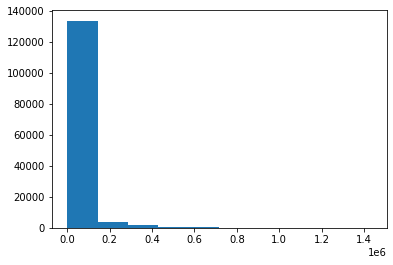

In [10]:
plt.hist(data.likes)

In [ ]:
# nltk corpus for sample twitter data
nltk.corpus.twitter_samples.fileids()

In [36]:
# preview tweets
train_pos_tweets = nltk.corpus.twitter_samples.strings('positive_tweets.json')
train_neg_tweets = nltk.corpus.twitter_samples.strings('negative_tweets.json')
nltk.corpus.twitter_samples.strings('negative_tweets.json')[:3]

['hopeless for tmr :(',
 "Everything in the kids section of IKEA is so cute. Shame I'm nearly 19 in 2 months :(",
 '@Hegelbon That heart sliding into the waste basket. :(']

In [ ]:
# example for cleaning data
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend([w.lower() for w in nltk.corpus.names.words()])

def skip_unwanted(pos_tuple):
    word, tag = pos_tuple
    if not word.isalpha() or word in stop_words:
        return False
    if tag.startswith("NN"):
        return False
    return True

data.text[1]
positive_words = [word for word, tag in filter(
    skip_unwanted,
    nltk.pos_tag(nltk.corpus.movie_reviews.words(categories=["pos"]))
)]
positive_words

In [39]:
data.Polarity[:6]

0    0.000000
1    0.000000
2    0.228095
3    0.266667
4   -0.053788
5    0.500000
Name: Polarity, dtype: float64

In [53]:
def compare_blob_nltk(row,sia):
    # print('\n',row.text)
    # print('blob polarity score',row.Polarity)
    # print('nltk polarity score',sia.polarity_scores(row.text))
    pol_scores = sia.polarity_scores(row.text)
    row['polarity_neg'] = pol_scores['neg']
    row['polarity_pos'] = pol_scores['pos']
    if pol_scores['pos'] == pol_scores['neg']: # neutral
        row['polarity_classif'] = 0  
    elif pol_scores['pos'] > pol_scores['neg']: # positive
        row['polarity_classif'] = 1  
    else: # negative
        row['polarity_classif'] = -1
    return row

In [54]:
sia = SentimentIntensityAnalyzer()
print('negative',sia.polarity_scores(train_neg_tweets[1])) # test on negative
print('positive',sia.polarity_scores(train_pos_tweets[1])) # test on negative
data.loc[:4,:].apply(lambda row: compare_blob_nltk(row,sia),axis=1)


negative {'neg': 0.26, 'neu': 0.58, 'pos': 0.16, 'compound': -0.3425}
positive {'neg': 0.145, 'neu': 0.585, 'pos': 0.27, 'compound': 0.6229}


,tweet_id,location,date,likes,retweets,text,index,city,state,is_state,...,Active,Incident_Rate,Total_Test_Results,Case_Fatality_Ratio,Testing_Rate,People_Tested,Mortality_Rate,polarity_neg,polarity_pos,polarity_classif
0,1.250000e+18,"Pomona, CA",4/4/2020,89921,34665,A day without Hispanics .... this country coul...,1,Pomona,California,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,0
1,1.250000e+18,"Santa Barbara, CA",4/21/2020,34308,5245,XO face masks are back to raise money and Iâ...,2,Santa Barbara,California,False,...,NaN,90.422652,NaN,NaN,765.392916,300100.0,3.607815,0.067,0.080,1
2,1.250000e+18,"California, USA",4/21/2020,0,0,@ImKingGinger Well aren't you special? My rela...,3,Not City,California,True,...,NaN,90.422652,NaN,NaN,765.392916,300100.0,3.607815,0.258,0.052,-1
3,1.250000e+18,"Arizona, USA",4/19/2020,4,0,@seanhannity If I was to stay home and eat ice...,4,Not City,Arizona,True,...,3755.0,67.772933,NaN,NaN,728.012918,65652.0,3.729982,0.162,0.110,-1
4,1.250000e+18,"Medford, MA",4/6/2020,0,0,"@MisagaLion @tedpanos Yup, CT. Governor spoke ...",5,Medford,Massachusetts,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.224,0.108,-1


In [58]:
sia = SentimentIntensityAnalyzer()
ddata = dd.from_pandas(data, npartitions=15)
ddata = ddata.map_partitions(lambda df: df.apply((lambda row: compare_blob_nltk(row,sia)), axis=1)).compute(scheduler='threads')
ddata.head()

C:\Users\tyler\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)
C:\Users\tyler\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


,tweet_id,location,date,likes,retweets,text,index,city,state,is_state,...,Active,Incident_Rate,Total_Test_Results,Case_Fatality_Ratio,Testing_Rate,People_Tested,Mortality_Rate,polarity_neg,polarity_pos,polarity_classif
0,1.250000e+18,"Pomona, CA",4/4/2020,89921,34665,A day without Hispanics .... this country coul...,1,Pomona,California,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,0
1,1.250000e+18,"Santa Barbara, CA",4/21/2020,34308,5245,XO face masks are back to raise money and Iâ...,2,Santa Barbara,California,False,...,NaN,90.422652,NaN,NaN,765.392916,300100.0,3.607815,0.067,0.080,1
2,1.250000e+18,"California, USA",4/21/2020,0,0,@ImKingGinger Well aren't you special? My rela...,3,Not City,California,True,...,NaN,90.422652,NaN,NaN,765.392916,300100.0,3.607815,0.258,0.052,-1
3,1.250000e+18,"Arizona, USA",4/19/2020,4,0,@seanhannity If I was to stay home and eat ice...,4,Not City,Arizona,True,...,3755.0,67.772933,NaN,NaN,728.012918,65652.0,3.729982,0.162,0.110,-1
4,1.250000e+18,"Medford, MA",4/6/2020,0,0,"@MisagaLion @tedpanos Yup, CT. Governor spoke ...",5,Medford,Massachusetts,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.224,0.108,-1


In [61]:
ddata.to_csv('../complete_data/complete_data_sentiment.csv',index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'complete_data/complete_data_sentiment.csv'